# Example workflow on Cotton shape

In [21]:
import pandas as pd
import requests
from rdflib import Namespace, Graph, URIRef, Literal, BNode
from rdflib.namespace import DCTERMS, DC, XSD, RDFS, DCAT, RDF, FOAF, NamespaceManager, SKOS
import os
import urllib.parse
from datetime import datetime
import uuid
import graphviz
from ShExJSG import Schema, ShExC, ShExJ
from ShExJSG.ShExJ import Shape, IRIREF, TripleConstraint, NodeConstraint, ShapeOr, EachOf, ShapeExternal, ShapeDecl, Annotation, ObjectLiteral
from shexviz import shex2dot

symbol = dict()
symbol["class"] = "oval"
symbol["datatype"] = "octagon"
symbol["literal"] = "rectangle"
symbol["iri"]="diamond"
symbol["bnode"]='point'
symbol["oneof"]='record'

rdf = Graph()

AGSCHEMAS = Namespace("https://agschemas.org/")
AGUNITS = Namespace("https://agunits.org")
WD = Namespace("http://www.wikidata.org/entity/")
WDT = Namespace("http://www.wikidata.org/prop/direct/")
SUBJECT = Namespace("http://cottonexample.org/")
HARVESTLOCATION = Namespace("http://cottonexample.org/location/")
NALT = Namespace("https://lod.nal.usda.gov/nalt/")

OBO = Namespace("http://purl.obolibrary.org/obo/")
rdf.bind("obo", "http://purl.obolibrary.org/obo/")
SCHEMA = Namespace("https://schema.org/")
QUDT = Namespace("http://qudt.org/schema/qudt/")
UNIT = Namespace("http://qudt.org/schema/qudt/Unit/")
AGUNIT = Namespace("https://agschemas.org/units/")


rdf.bind("sio", "http://semanticscience.org/resource/")
rdf.bind("wd", "http://www.wikidata.org/entity/")
rdf.bind("wdt", "http://www.wikidata.org/prop/direct/")

def add2graphviz(command=None, arg1=None, arg2=None, shape=None, label=None):
    if command == "attr":
        localviz.attr(arg1, shape=shape)
        schema.attr(arg1, shape=shape)
    if command == "node":
        localviz.node(arg1,label=label)
        schema.node(arg1,label=label)
    if command == "edge":
        localviz.edge(arg1, arg2, label=label)
        schema.edge(arg1, arg2, label=label)

In [3]:
filename = 'data/Dawson3242890.csv'
fileURI = URIRef("https://www.protocols.io/file/tba/Dawson3242890.csv")

# The original data
In this chapter the tabular data from the previous chapter will be converted into linked data. As we discussed earlier, in linked data the data is mainly represented by using IRIs and placing those URIs in data shapes. 

This already starts with describing the data itself. 

## Schema of meta data on weather dataset exampe
Below is graph representation on the metadata on dataset 1. The following symbols are used.


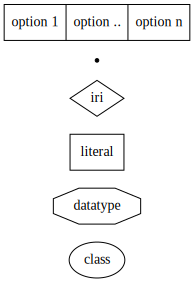

In [5]:
md_schema = graphviz.Digraph(filename, filename=filename+'pda_weather.gv')
md_schema.graph_attr['rankdir'] = 'LR'

for key in symbol.keys():
    md_schema.attr('node', shape=symbol[key])
    if key == "oneof":
        md_schema.node(key, label="{option 1|option ..|option n}")
    else:
        md_schema.node(key)
md_schema

Below it the (proposed) shape for the metadata. 

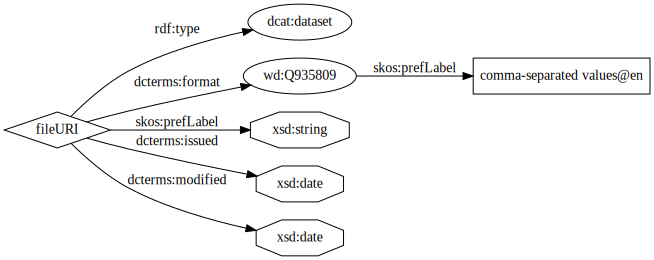

In [6]:

schema = graphviz.Digraph(filename, filename=filename+'.gv')
schema.graph_attr['rankdir'] = 'LR'
# graphviz
schema.attr('node', shape=symbol["iri"])
schema.node('fileURI')
schema.attr('node', shape=symbol["class"])
schema.node('dcatdataset', label='dcat:dataset')
schema.node('Q935809', label='wd:Q935809')
schema.attr('node', shape=symbol["literal"])
schema.node('comma-separated values@en')
schema.attr('node', shape='octagon')
schema.node('filename', label='xsd:string')
schema.node('filedatecreated', label='xsd:date')
schema.node('filedatemodified', label='xsd:date')
schema.edge('fileURI', 'dcatdataset', label='rdf:type')
schema.edge('fileURI', 'Q935809', label='dcterms:format')
schema.edge('Q935809', 'comma-separated values@en', label='skos:prefLabel')
schema.edge('fileURI', 'filename', label="skos:prefLabel")
schema.edge('fileURI', 'filedatecreated', label="dcterms:issued")
schema.edge('fileURI', 'filedatemodified', label="dcterms:modified")

# ShEx
dataexpressions = []
dataexpressions.append(TripleConstraint(predicate=IRIREF(RDF.type),valueExpr=NodeConstraint(values=[DCAT.Dataset])))
dataexpressions.append(TripleConstraint(predicate=IRIREF(DCTERMS.format),valueExpr=NodeConstraint(values=[IRIREF(WD.Q63082925)]), annotations=[Annotation(RDFS.label,ObjectLiteral("Office Open XML Spreadsheet Document", language="en"))]))
dataexpressions.append(TripleConstraint(predicate=IRIREF(RDFS.label), valueExpr=NodeConstraint(datatype=XSD.string)))
dataexpressions.append(TripleConstraint(predicate=IRIREF(DCTERMS.issued), valueExpr=NodeConstraint(datatype=XSD.dateTime)))
dataexpressions.append(TripleConstraint(predicate=IRIREF(DCTERMS.modified), valueExpr=NodeConstraint(datatype=XSD.dateTime)))

# RDF
rdf = Graph()
rdf.add((fileURI, RDF.type, DCAT.Dataset))
rdf.add((fileURI, DCTERMS.format, WD.Q63082925))
rdf.add((WD.Q63082925, RDFS.label, Literal("Office Open XML Spreadsheet Document", lang="en")))
rdf.add((fileURI, RDFS.label, Literal(filename, datatype=XSD.string)))
datecreated = os.path.getctime(filename)
rdf.add((fileURI, DCTERMS.issued, Literal(datetime.fromtimestamp(datecreated).strftime('%Y-%m-%dT%H:%M:%SZ'), datatype=XSD.dateTime)))
datemodified = os.path.getmtime(filename)
rdf.add((fileURI, DCTERMS.modified, Literal(datetime.fromtimestamp(datemodified).strftime('%Y-%m-%dT%H:%M:%SZ'), datatype=XSD.dateTime)))

cotton = Schema()
shapesns = 'http://agschemas.org/'
startshape = shapesns + "#cotton"
cotton.shapes = [Shape(startshape, expression=EachOf(expressions=dataexpressions))]
cotton.start = startshape

# print(str(ShExC(gbm1, base=shapesns, namespaces=rdf.namespace_manager)))
schema

### Load (synthetic) data

In [7]:
pd.set_option('display.max_columns', None)
subjects = pd.read_csv(filename,index_col=False)
subjects

STATION                 NAME        DATE  DAPR  MDPR  PRCP  SNOW  \
0    USC00415013  LAMESA 1 SSE, TX US  2010-03-01   NaN   NaN  0.44   0.0   
1    USC00415013  LAMESA 1 SSE, TX US  2010-03-02   NaN   NaN  0.02   0.0   
2    USC00415013  LAMESA 1 SSE, TX US  2010-03-03   NaN   NaN  0.00   0.0   
3    USC00415013  LAMESA 1 SSE, TX US  2010-03-04   NaN   NaN  0.00   0.0   
4    USC00415013  LAMESA 1 SSE, TX US  2010-03-05   NaN   NaN  0.00   0.0   
..           ...                  ...         ...   ...   ...   ...   ...   
240  USC00415013  LAMESA 1 SSE, TX US  2010-10-27   NaN   NaN  0.00   0.0   
241  USC00415013  LAMESA 1 SSE, TX US  2010-10-28   NaN   NaN  0.00   0.0   
242  USC00415013  LAMESA 1 SSE, TX US  2010-10-29   NaN   NaN  0.00   0.0   
243  USC00415013  LAMESA 1 SSE, TX US  2010-10-30   NaN   NaN  0.00   0.0   
244  USC00415013  LAMESA 1 SSE, TX US  2010-10-31   NaN   NaN  0.00   0.0   

     SNWD  TMAX  TMIN  TOBS  WT01  WT11  
0     0.0    60  36.0  36.0   NaN   NaN  
1     0.0    41  27.0  27.0   NaN   NaN  
2     0.0    59  27.0  33.0   NaN   NaN  
3     0.0    68  33.0  35.0   NaN   NaN  
4     0.0    71  33.0  43.0   NaN   NaN  
..    ...   ...   ...   ...   ...   ...  
240   0.0    74  40.0  47.0   NaN   NaN  
241   0.0    76  40.0  40.0   NaN   NaN  
242   0.0    67  32.0  32.0   NaN   NaN  
243   0.0    73  32.0  45.0   NaN   NaN  
244   0.0    90  39.0  45.0   NaN   NaN  

[245 rows x 13 columns]

# Shape modelling
## Weather Shape
* Max and min temp
* Precipitation
* Cloud cover


 example: <http://www.example.org/>
 agschemas: <https://agschemas.org/>
 ghcnd: <http://example.com/weather/GHCND>
 xsd: <http://www.w3.org/2001/XMLSchema#>
 nalt: <https://lod.nal.usda.gov/nalt/>
 rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
 dct: <http://purl.org/dc/terms/>
 schema: <http://schema.org/>
 qudt: <http://qudt.org/schema/qudt/>
 quantitykind: <http://qudt.org/vocab/quantitykind/>
 unit: <http://qudt.org/vocab/unit/>
Valid: False
None
http://www.example.org/location
TripleConstraint(type='TripleConstraint', id=None, inverse=None, predicate='https://agschemas.org/nearbyWeatherStation', valueExpr='http://www.example.org/weatherStation', min=1, max=-1, onShapeExpression=None, semActs=None, annotations=None)
http://www.example.org/weatherStation
TripleConstraint(type='TripleConstraint', id=None, inverse=None, predicate='http://www.w3.org/1999/02/22-rdf-syntax-ns#type', valueExpr=NodeConstraint(type='NodeConstraint', id=None, nodeKind=None, datatype='https://lod.nal.usd

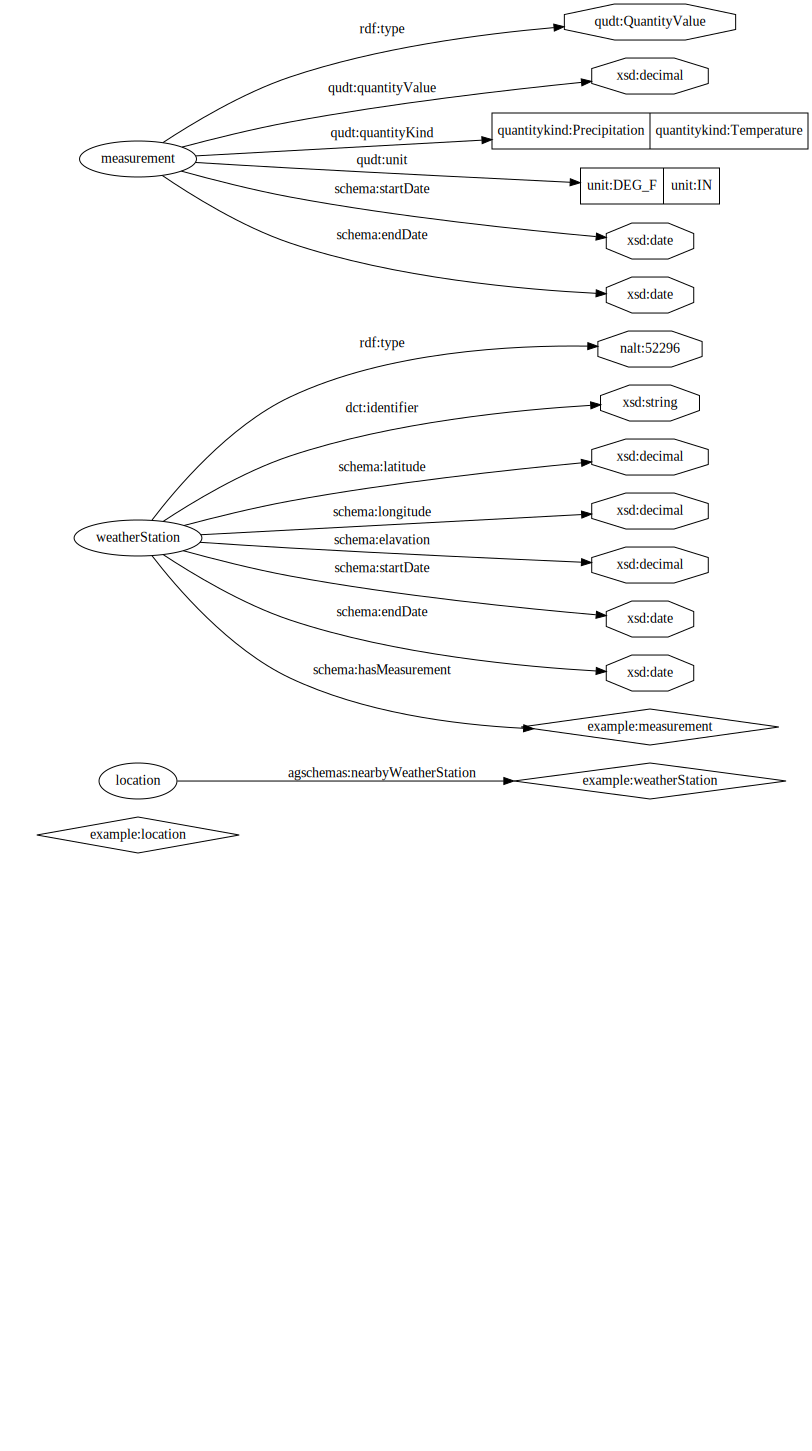

In [23]:
shex = open("shex/weather.shex", 'r').read()
graphvizSchema = shex2dot.shex2dot(shex, "weather")
graphvizSchema